In [1]:
#importing dependencies related to nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

#importing dependencies related to image transformations
import torchvision
from torchvision import transforms
from PIL import Image

#importing dependencies related to data loading
from torchvision import datasets
from torch.utils.data import DataLoader

#importing Tensorboard for data visualization
from torch.utils.tensorboard import SummaryWriter

In [2]:
#defining image transformations

image_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    #transforms.RandomRotation(degrees=15),
    #transforms.ColorJitter(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [3]:
path_data=r"F:\New folder\mask detection pytorch\data_2\Face Mask Dataset\Test"
# loading data
data = datasets.ImageFolder(root=path_data, transform=image_transforms)

dataloaders =DataLoader(data, batch_size=100, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


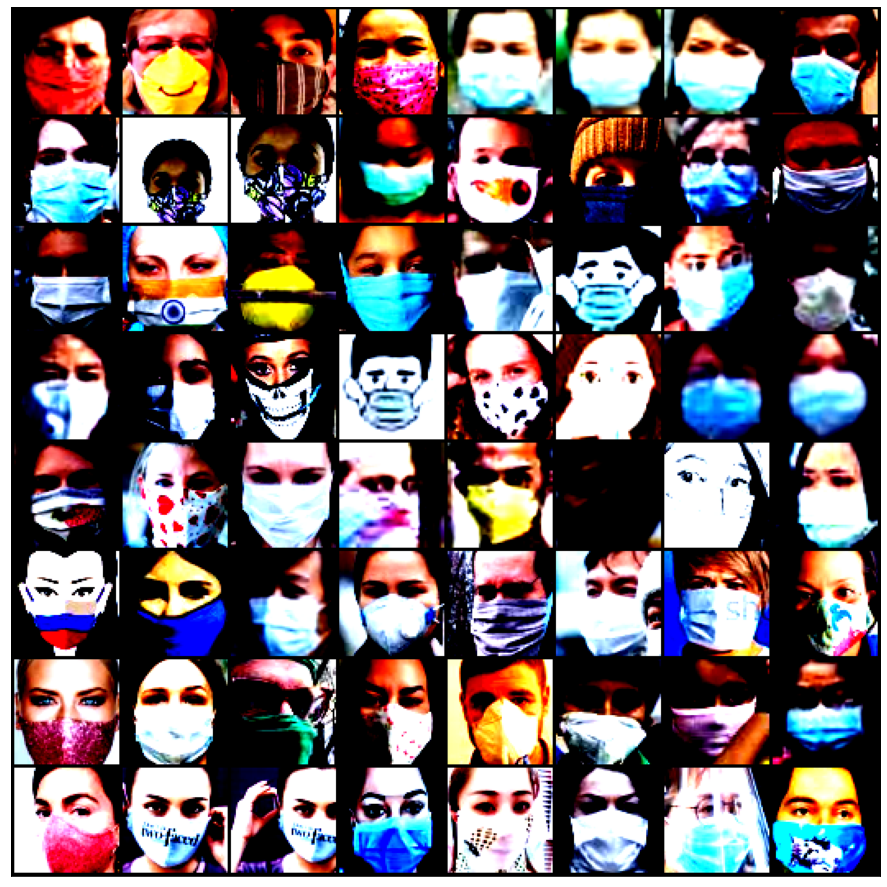

In [4]:
from torchvision.utils import make_grid
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

#stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
stats = ([0, 0, 0],[1, 1,1])

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(dataloaders)

In [6]:
path_data=r"model_mobilenet.pth"

model_=torch.load(path_data)

In [7]:
#checking GPU Avaibility
if torch.cuda.is_available():
    print('training on GPU')
    device = torch.device("cuda:0")
else:
    print('training on CPU')
    device = torch.device("cpu")

training on CPU


In [8]:
model_=model_.to(device)

In [9]:
dataloaders.dataset.class_to_idx   

{'WithMask': 0, 'WithoutMask': 1}

In [10]:
#testing data
def test_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted,'\n\n',outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

In [13]:
import numpy as np


In [14]:
y_pred = []
y_true = []
# iterate over test data
with torch.no_grad():
    for inputs, labels in dataloaders:
            output = model_(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

# constant for classes
classes = data.classes

In [15]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                     columns = [i for i in classes])
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])


In [16]:
df_cm

,WithMask,WithoutMask
WithMask,483,0
WithoutMask,3,506


In [17]:
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])

<AxesSubplot:>

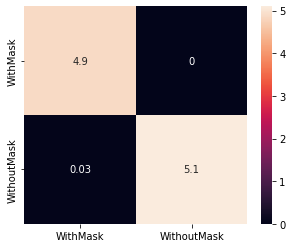

In [18]:
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output_1acc_2.png')